In [394]:
# Standard Imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

from pprint import pprint

In [403]:

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [429]:
train = pd.read_csv('train_s3TEQDk.csv')
pprint(train.shape)

(245725, 11)


In [430]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [431]:
train.drop("ID", axis=1, inplace=True)

In [432]:
train["Is_Lead"].value_counts(normalize=True)

0    0.762792
1    0.237208
Name: Is_Lead, dtype: float64

Target calss is imbalanced

In [433]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
Gender                 245725 non-null object
Age                    245725 non-null int64
Region_Code            245725 non-null object
Occupation             245725 non-null object
Channel_Code           245725 non-null object
Vintage                245725 non-null int64
Credit_Product         216400 non-null object
Avg_Account_Balance    245725 non-null int64
Is_Active              245725 non-null object
Is_Lead                245725 non-null int64
dtypes: int64(4), object(6)
memory usage: 18.7+ MB


### Covert Gender, Credit_Product, Is_Active to numeric

In [434]:
train['Gender'] = train['Gender'].replace({'Male':1, 'Female':0})
train['Credit_Product'] = train['Credit_Product'].fillna('None')
train['Is_Active'] = train['Is_Active'].replace({'Yes':1, 'No':0})

train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,RG268,Other,X3,43,No,1045696,0,0
1,0,30,RG277,Salaried,X1,32,No,581988,0,0
2,0,56,RG268,Self_Employed,X3,26,No,1484315,1,0
3,1,34,RG270,Salaried,X1,19,No,470454,0,0
4,0,30,RG282,Salaried,X1,33,No,886787,0,0


In [436]:
train['Credit_Product'].value_counts()

No      144357
Yes      72043
None     29325
Name: Credit_Product, dtype: int64

### OneHot encoding Occupation and  Channel_Code

In [437]:
def one_hot_encode(col):
    dummies = pd.get_dummies(train[col], prefix=col, prefix_sep='_', drop_first=True)
    return dummies

In [438]:
train = pd.concat([train, one_hot_encode('Occupation'), one_hot_encode('Channel_Code'), one_hot_encode('Credit_Product')], axis=1)
train.drop(['Occupation', 'Channel_Code', 'Credit_Product'], axis=1, inplace=True)

train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes
0,0,73,RG268,43,1045696,0,0,1,0,0,0,1,0,0,0
1,0,30,RG277,32,581988,0,0,0,1,0,0,0,0,0,0
2,0,56,RG268,26,1484315,1,0,0,0,1,0,1,0,0,0
3,1,34,RG270,19,470454,0,0,0,1,0,0,0,0,0,0
4,0,30,RG282,33,886787,0,0,0,1,0,0,0,0,0,0


In [439]:
train.columns

Index(['Gender', 'Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance',
       'Is_Active', 'Is_Lead', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Channel_Code_X2', 'Channel_Code_X3',
       'Channel_Code_X4', 'Credit_Product_None', 'Credit_Product_Yes'],
      dtype='object')

### Target Encoding the Region_Code columns

In [440]:
from category_encoders.target_encoder import TargetEncoder
enc = TargetEncoder(cols=['Region_Code'], handle_unknown='value', drop_invariant=False, return_df=True, min_samples_leaf=1)
train['Region_Code_Encoded'] = enc.fit_transform(train['Region_Code'], train[['Is_Lead']])


In [441]:
# train.drop('Region_Code', inplace=True, axis=1)
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded
0,0,73,RG268,43,1045696,0,0,1,0,0,0,1,0,0,0,0.299800
1,0,30,RG277,32,581988,0,0,0,1,0,0,0,0,0,0,0.231951
2,0,56,RG268,26,1484315,1,0,0,0,1,0,1,0,0,0,0.299800
3,1,34,RG270,19,470454,0,0,0,1,0,0,0,0,0,0,0.144301
4,0,30,RG282,33,886787,0,0,0,1,0,0,0,0,0,0,0.192143


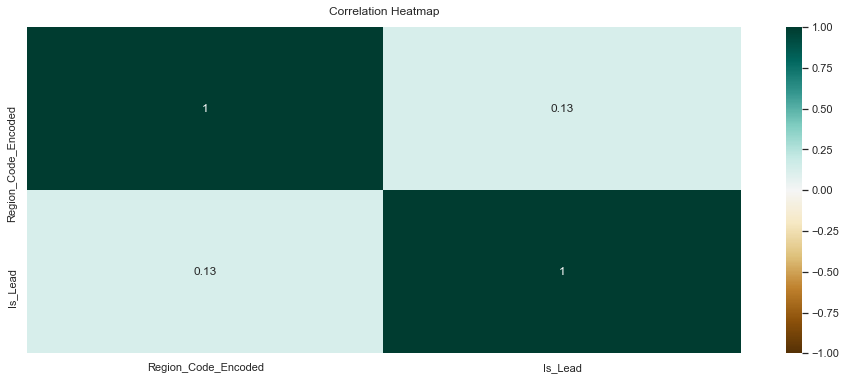

In [442]:

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train[['Region_Code_Encoded', 'Is_Lead']].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Transforminf Account Balance to LogTranform

In [443]:
train['Log_Avg_Account_Balance'] = np.log2(train['Avg_Account_Balance'])
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance
0,0,73,RG268,43,1045696,0,0,1,0,0,0,1,0,0,0,0.299800,19.996032
1,0,30,RG277,32,581988,0,0,0,1,0,0,0,0,0,0,0.231951,19.150630
2,0,56,RG268,26,1484315,1,0,0,0,1,0,1,0,0,0,0.299800,20.501366
3,1,34,RG270,19,470454,0,0,0,1,0,0,0,0,0,0,0.144301,18.843694
4,0,30,RG282,33,886787,0,0,0,1,0,0,0,0,0,0,0.192143,19.758228


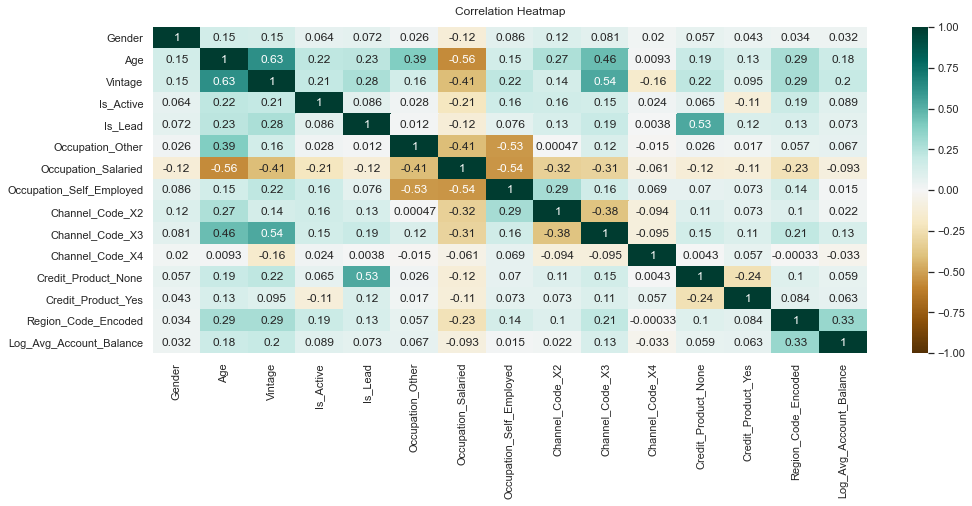

In [444]:
dataset = train.drop(['Region_Code','Avg_Account_Balance'], axis=1)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [445]:
bins= [20,30,40,50,60,70, 80, 90]
labels = ['20+','30+','40+','50+','60+','70+','80+']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)


enc=LabelEncoder()
train['AgeGroup_Enc'] = enc.fit_transform(train['AgeGroup'])
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc
0,0,73,RG268,43,1045696,0,0,1,0,0,0,1,0,0,0,0.299800,19.996032,70+,5
1,0,30,RG277,32,581988,0,0,0,1,0,0,0,0,0,0,0.231951,19.150630,30+,1
2,0,56,RG268,26,1484315,1,0,0,0,1,0,1,0,0,0,0.299800,20.501366,50+,3
3,1,34,RG270,19,470454,0,0,0,1,0,0,0,0,0,0,0.144301,18.843694,30+,1
4,0,30,RG282,33,886787,0,0,0,1,0,0,0,0,0,0,0.192143,19.758228,30+,1


In [446]:
bins= list(range(0, 12*13, 12))
labels = [str(i//12)+'+' for i in bins[:-1]]
train['Vintage_Group'] = pd.cut(train['Vintage'], bins=bins, labels=labels, right=False)

enc=LabelEncoder()
train['Vintage_Group_Enc'] = enc.fit_transform(train['Vintage_Group'])
train.head()

,Gender,Age,Region_Code,Vintage,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,...,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc,Vintage_Group,Vintage_Group_Enc
0,0,73,RG268,43,1045696,0,0,1,0,0,...,1,0,0,0,0.299800,19.996032,70+,5,3+,5
1,0,30,RG277,32,581988,0,0,0,1,0,...,0,0,0,0,0.231951,19.150630,30+,1,2+,4
2,0,56,RG268,26,1484315,1,0,0,0,1,...,1,0,0,0,0.299800,20.501366,50+,3,2+,4
3,1,34,RG270,19,470454,0,0,0,1,0,...,0,0,0,0,0.144301,18.843694,30+,1,1+,1
4,0,30,RG282,33,886787,0,0,0,1,0,...,0,0,0,0,0.192143,19.758228,30+,1,2+,4


In [447]:
X=train.drop(['Age', 'Region_Code', 'Vintage', 'Avg_Account_Balance', 'AgeGroup', 'Vintage_Group'], axis=1)

In [448]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 15 columns):
Gender                      245725 non-null int64
Is_Active                   245725 non-null int64
Is_Lead                     245725 non-null int64
Occupation_Other            245725 non-null uint8
Occupation_Salaried         245725 non-null uint8
Occupation_Self_Employed    245725 non-null uint8
Channel_Code_X2             245725 non-null uint8
Channel_Code_X3             245725 non-null uint8
Channel_Code_X4             245725 non-null uint8
Credit_Product_None         245725 non-null uint8
Credit_Product_Yes          245725 non-null uint8
Region_Code_Encoded         245725 non-null float64
Log_Avg_Account_Balance     245725 non-null float64
AgeGroup_Enc                245725 non-null int32
Vintage_Group_Enc           245725 non-null int32
dtypes: float64(2), int32(2), int64(3), uint8(8)
memory usage: 13.1 MB


In [449]:
y = X['Is_Lead']
X = X.drop('Is_Lead', axis=1)
X.head()

,Gender,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_None,Credit_Product_Yes,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup_Enc,Vintage_Group_Enc
0,0,0,1,0,0,0,1,0,0,0,0.299800,19.996032,5,5
1,0,0,0,1,0,0,0,0,0,0,0.231951,19.150630,1,4
2,0,1,0,0,1,0,1,0,0,0,0.299800,20.501366,3,4
3,1,0,0,1,0,0,0,0,0,0,0.144301,18.843694,1,1
4,0,0,0,1,0,0,0,0,0,0,0.192143,19.758228,1,4


In [450]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101, stratify=y)

In [176]:
from sklearn.metrics import roc_auc_score, classification_report

In [451]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [173]:
# sc = StandardScaler()
# X_train_os = sc.fit_transform(X_train_os)
# X_test = sc.fit_transform(X_test)

In [132]:
%%time
rf_Model = RandomForestClassifier(max_depth=10)


rf_Model.fit(X_train_os, y_train_os)
print('Train AUC Score: {}'.format(roc_auc_score(y_train_os, rf_Model.predict(X_train_os))))

print('Test AUC Score: {}'.format(roc_auc_score(y_test, rf_Model.predict(X_test))))

Train AUC Score: 0.7502576879756989
Test AUC Score: 0.7357228839728609
Wall time: 39.1 s


Text(0.5, 0, 'Random Forest Feature Importance')

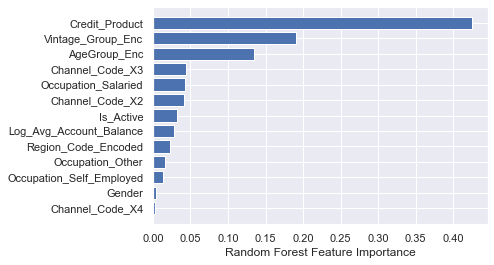

In [133]:


sorted_idx = rf_Model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_Model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [97]:
X_train.columns[sorted_idx]

Index(['Channel_Code_X4', 'Occupation_Self_Employed', 'Gender',
       'Occupation_Other', 'Is_Active', 'Channel_Code_X3', 'Channel_Code_X2',
       'Occupation_Salaried', 'Region_Code_Encoded', 'AgeGroup_Enc',
       'Vintage_Group_Enc', 'Log_Avg_Account_Balance', 'Credit_Product'],
      dtype='object')

In [134]:
# Number of trees in random forest
n_estimators = [200]
# Maximum number of levels in tree
max_depth = [15,18, 21]
# Minimum number of samples required to split a node
min_samples_split = [20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto', 'sqrt'], 'max_depth': [15, 18, 21], 'min_samples_split': [20, 30], 'min_samples_leaf': [10, 15], 'bootstrap': [True, False]}


In [135]:

from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf_Model, scoring='roc_auc',
                        param_grid = param_grid, cv = 10, 
                        verbose=10, n_jobs = 4)

In [136]:
%%time
rf_Grid.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Wall time: 2h 52min 43s


GridSearchCV(cv=10, estimator=RandomForestClassifier(max_depth=10), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [15, 18, 21],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [10, 15],
                         'min_samples_split': [20, 30], 'n_estimators': [200]},
             scoring='roc_auc', verbose=10)

In [137]:
rf_Grid.best_estimator_

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=15,
                       min_samples_split=30, n_estimators=200)

In [138]:
rf_Grid.best_score_

0.7993714162112534

In [139]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 30,
 'n_estimators': 200}

In [145]:
%%time
rf_Model_1 = RandomForestClassifier(max_depth=15,
                                   max_features='sqrt',
                                   min_samples_leaf=15,
                                   min_samples_split=30,
                                   n_estimators=200,
                                   bootstrap=True)


rf_Model_1.fit(X_train_os, y_train_os)
print('Train AUC Score: {}'.format(roc_auc_score(y_train_os, rf_Model_1.predict(X_train_os))))

print('Test AUC Score: {}'.format(roc_auc_score(y_test, rf_Model_1.predict(X_test))))

Train AUC Score: 0.780173384757159
Test AUC Score: 0.7326554370134503
Wall time: 1min 47s


In [147]:
%%time
rf_Model_2 = RandomForestClassifier(max_depth=20,
                                   max_features='sqrt',
                                   min_samples_leaf=15,
                                   min_samples_split=30,
                                   n_estimators=200,
                                   bootstrap=True)


rf_Model_2.fit(X_train_os, y_train_os)
print('Train AUC Score: {}'.format(roc_auc_score(y_train_os, rf_Model_2.predict(X_train_os))))

print('Test AUC Score: {}'.format(roc_auc_score(y_test, rf_Model_2.predict(X_test))))

Train AUC Score: 0.7993003174169766
Test AUC Score: 0.7280405043170991
Wall time: 1min 49s


In [149]:
%%time
rf_model_3 = RandomForestClassifier(max_depth=15,
                                   max_features='sqrt',
                                   min_samples_leaf=15,
                                   min_samples_split=30,
                                   n_estimators=500,
                                   bootstrap=True)


rf_model_3.fit(X_train_os, y_train_os)
print('Train AUC Score: {}'.format(roc_auc_score(y_train_os, rf_model_3.predict(X_train_os))))

print('Test AUC Score: {}'.format(roc_auc_score(y_test, rf_model_3.predict(X_test))))

Train AUC Score: 0.7796580088057613
Test AUC Score: 0.7314922484167847
Wall time: 4min 20s


In [150]:
%%time
rf_Model_4 = RandomForestClassifier(max_depth=25,
                                   max_features='sqrt',
                                   min_samples_leaf=15,
                                   min_samples_split=30,
                                   n_estimators=1000,
                                   bootstrap=True)


rf_Model_4.fit(X_train_os, y_train_os)
print('Train AUC Score: {}'.format(roc_auc_score(y_train_os, rf_Model_4.predict(X_train_os))))

print('Test AUC Score: {}'.format(roc_auc_score(y_test, rf_Model_4.predict(X_test))))

Train AUC Score: 0.8023993992969043
Test AUC Score: 0.7284648787195361
Wall time: 10min 53s


In [151]:
import xgboost as xgb
# from xgboost.sklearn import XGBClassifier

In [178]:
param_dist = {'learning_rate' :0.01,
             'n_estimators':1000,
             'max_depth':5,
             'min_child_weight':1,
             'gamma':0,
             'subsample':0.8,
             'colsample_bytree':0.8,
             'objective': 'binary:logistic',
              
             'nthread':4,
             'seed':42}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_train_os, y_train_os,
        eval_set=[(X_train_os, y_train_os), (X_test, y_test)],
        eval_metric='auc',
        early_stopping_rounds=10,
        verbose=True)

evals_result = clf.evals_result()
print(max(evals_result['validation_1']['auc']))

[0]	validation_0-auc:0.78017	validation_1-auc:0.78103
[1]	validation_0-auc:0.79366	validation_1-auc:0.79613
[2]	validation_0-auc:0.79459	validation_1-auc:0.79725
[3]	validation_0-auc:0.79444	validation_1-auc:0.79703
[4]	validation_0-auc:0.79509	validation_1-auc:0.79746
[5]	validation_0-auc:0.79487	validation_1-auc:0.79730
[6]	validation_0-auc:0.79695	validation_1-auc:0.79920
[7]	validation_0-auc:0.79657	validation_1-auc:0.79875
[8]	validation_0-auc:0.79729	validation_1-auc:0.80046
[9]	validation_0-auc:0.79699	validation_1-auc:0.80012
[10]	validation_0-auc:0.79669	validation_1-auc:0.79975
[11]	validation_0-auc:0.79680	validation_1-auc:0.79991
[12]	validation_0-auc:0.79712	validation_1-auc:0.79990
[13]	validation_0-auc:0.79723	validation_1-auc:0.80003
[14]	validation_0-auc:0.79715	validation_1-auc:0.79991
[15]	validation_0-auc:0.79713	validation_1-auc:0.79993
[16]	validation_0-auc:0.79657	validation_1-auc:0.79938
[17]	validation_0-auc:0.79668	validation_1-auc:0.79948
[18]	validation_0-au

In [452]:
test_data = pd.read_csv('test_mSzZ8RL.csv')
test_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [314]:
# test_data.drop('ID', axis=1, inplace=True)

In [315]:
test_data['Gender'].value_counts()

Male      57705
Female    47607
Name: Gender, dtype: int64

In [316]:
test_data['Gender'] = test_data['Gender'].replace({'Male':1, 'Female':0})


In [317]:
#
test_data['Is_Active'] = test_data['Is_Active'].replace({'Yes':1, 'No':0})

test_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,1,29,RG254,Other,X1,25,Yes,742366,0
1,CCMEWNKY,1,43,RG268,Other,X2,49,NaN,925537,0
2,VK3KGA9M,1,31,RG270,Salaried,X1,14,No,215949,0
3,TT8RPZVC,1,29,RG272,Other,X1,33,No,868070,0
4,SHQZEYTZ,0,29,RG270,Other,X1,19,No,657087,0


In [318]:
test_data['Credit_Product'] = test_data['Credit_Product'].replace({'Yes':1, 'No':0})

In [319]:
test_data['Credit_Product'] = test_data['Credit_Product'].fillna(0)

In [320]:
test_data['Credit_Product'].value_counts(normalize=True)#= train['Credit_Product'].replace({'Yes':1, 'No':0})

0.0    0.703908
1.0    0.296092
Name: Credit_Product, dtype: float64

In [321]:
test_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,1,29,RG254,Other,X1,25,1.0,742366,0
1,CCMEWNKY,1,43,RG268,Other,X2,49,0.0,925537,0
2,VK3KGA9M,1,31,RG270,Salaried,X1,14,0.0,215949,0
3,TT8RPZVC,1,29,RG272,Other,X1,33,0.0,868070,0
4,SHQZEYTZ,0,29,RG270,Other,X1,19,0.0,657087,0


In [322]:
def one_hot_encode(col):
    dummies = pd.get_dummies(test_data[col], prefix=col, prefix_sep='_', drop_first=True)
    return dummies

test_data = pd.concat([test_data, one_hot_encode('Occupation'), one_hot_encode('Channel_Code')], axis=1)
test_data.drop(['Occupation', 'Channel_Code'], axis=1, inplace=True)


test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
0,VBENBARO,1,29,RG254,25,1.0,742366,0,1,0,0,0,0,0
1,CCMEWNKY,1,43,RG268,49,0.0,925537,0,1,0,0,1,0,0
2,VK3KGA9M,1,31,RG270,14,0.0,215949,0,0,1,0,0,0,0
3,TT8RPZVC,1,29,RG272,33,0.0,868070,0,1,0,0,0,0,0
4,SHQZEYTZ,0,29,RG270,19,0.0,657087,0,1,0,0,0,0,0


In [323]:
from category_encoders.target_encoder import TargetEncoder

enc = TargetEncoder(cols=['Region_Code'], handle_unknown='value', drop_invariant=False, return_df=True, min_samples_leaf=1)
train['Region_Code_Encoded'] = enc.fit_transform(train['Region_Code'], train[['Is_Lead']])

test_data['Region_Code_Encoded'] = enc.transform(test_data['Region_Code'])


In [324]:
test_data['Log_Avg_Account_Balance'] = np.log2(test_data['Avg_Account_Balance'])

test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Region_Code_Encoded,Log_Avg_Account_Balance
0,VBENBARO,1,29,RG254,25,1.0,742366,0,1,0,0,0,0,0,0.212854,19.501771
1,CCMEWNKY,1,43,RG268,49,0.0,925537,0,1,0,0,1,0,0,0.299800,19.819931
2,VK3KGA9M,1,31,RG270,14,0.0,215949,0,0,1,0,0,0,0,0.144301,17.720331
3,TT8RPZVC,1,29,RG272,33,0.0,868070,0,1,0,0,0,0,0,0.219916,19.727452
4,SHQZEYTZ,0,29,RG270,19,0.0,657087,0,1,0,0,0,0,0,0.144301,19.325725


In [325]:
bins= [20,30,40,50,60,70, 80, 90]
labels = ['20+','30+','40+','50+','60+','70+','80+']
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=bins, labels=labels, right=False)


enc=LabelEncoder()
test_data['AgeGroup_Enc'] = enc.fit_transform(test_data['AgeGroup'])
test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc
0,VBENBARO,1,29,RG254,25,1.0,742366,0,1,0,0,0,0,0,0.212854,19.501771,20+,0
1,CCMEWNKY,1,43,RG268,49,0.0,925537,0,1,0,0,1,0,0,0.299800,19.819931,40+,2
2,VK3KGA9M,1,31,RG270,14,0.0,215949,0,0,1,0,0,0,0,0.144301,17.720331,30+,1
3,TT8RPZVC,1,29,RG272,33,0.0,868070,0,1,0,0,0,0,0,0.219916,19.727452,20+,0
4,SHQZEYTZ,0,29,RG270,19,0.0,657087,0,1,0,0,0,0,0,0.144301,19.325725,20+,0


In [326]:
bins= list(range(0, 12*13, 12))
labels = [str(i//12)+'+' for i in bins[:-1]]
test_data['Vintage_Group'] = pd.cut(test_data['Vintage'], bins=bins, labels=labels, right=False)

enc=LabelEncoder()
test_data['Vintage_Group_Enc'] = enc.fit_transform(test_data['Vintage_Group'])
test_data.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup,AgeGroup_Enc,Vintage_Group,Vintage_Group_Enc
0,VBENBARO,1,29,RG254,25,1.0,742366,0,1,0,0,0,0,0,0.212854,19.501771,20+,0,2+,4
1,CCMEWNKY,1,43,RG268,49,0.0,925537,0,1,0,0,1,0,0,0.299800,19.819931,40+,2,4+,6
2,VK3KGA9M,1,31,RG270,14,0.0,215949,0,0,1,0,0,0,0,0.144301,17.720331,30+,1,1+,1
3,TT8RPZVC,1,29,RG272,33,0.0,868070,0,1,0,0,0,0,0,0.219916,19.727452,20+,0,2+,4
4,SHQZEYTZ,0,29,RG270,19,0.0,657087,0,1,0,0,0,0,0,0.144301,19.325725,20+,0,1+,1


In [327]:
test_data.drop(['Age', 'Region_Code', 'Vintage', 'AgeGroup', 'Vintage_Group'], axis=1, inplace=True)

In [328]:
test_data.shape

(105312, 15)

In [307]:
param_dist = {'learning_rate' :0.01,
             'n_estimators':1000,
             'max_depth':5,
             'min_child_weight':1,
             'gamma':10,
             'reg_alpha' : 0.3
             'subsample':0.8,
             'colsample_bytree':0.8,
             'objective': 'binary:logistic',
             'eval_metrics':'auc',
             'nthread':4,
             'seed':42}

model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
xbg_cv = xgb.XGBClassifier(**param_dist)

SyntaxError: invalid syntax (<ipython-input-307-7f2fa4592a0f>, line 2)

In [329]:
test_data.columns

Index(['ID', 'Gender', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed',
       'Channel_Code_X2', 'Channel_Code_X3', 'Channel_Code_X4',
       'Region_Code_Encoded', 'Log_Avg_Account_Balance', 'AgeGroup_Enc',
       'Vintage_Group_Enc'],
      dtype='object')

In [330]:
test_data_id = test_data['ID']
test_data.drop('ID', inplace=True, axis=1)

In [331]:
test_data.drop('Avg_Account_Balance', inplace=True, axis=1)

In [332]:
pred = clf.predict(test_data)

In [338]:
submission = pd.DataFrame({'ID':test_data_id, 'Is_Lead':pred})

In [341]:
submission["Is_Lead"].value_counts(normalize=True)

0    0.631096
1    0.368904
Name: Is_Lead, dtype: float64

In [343]:
submission.to_csv('xgboost_sub_1.csv', index=False)

In [333]:
submit['Is_Lead'] = pred

In [334]:
submit.to_csv('sample')

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0
5,MZZAQMPT,0
6,Y88TW36I,0
7,3UGOAQNU,0
8,VVUKMUJT,1
9,9R363ZXS,1


In [187]:
X.head()

,Gender,Credit_Product,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Region_Code_Encoded,Log_Avg_Account_Balance,AgeGroup_Enc,Vintage_Group_Enc
0,0,0.0,0,1,0,0,0,1,0,0.299800,19.996032,5,5
1,0,0.0,0,0,1,0,0,0,0,0.231951,19.150630,1,4
2,0,0.0,1,0,0,1,0,1,0,0.299800,20.501366,3,4
3,1,0.0,0,0,1,0,0,0,0,0.144301,18.843694,1,1
4,0,0.0,0,0,1,0,0,0,0,0.192143,19.758228,1,4


In [390]:
from sklearn.model_selection import GridSearchCV
# PARAMETERS = {"subsample":[0.5, 0.75, 1],
#                 "colsample_bytree":[0.5, 0.75, 1],
#                 "max_depth":[10,12,15],
#                 "min_child_weight":[1,5,15],
#                 "learning_rate":[0.3, 0.1, 0.03],
#                 "n_estimators":[100]}
PARAMETERS = {"subsample":[0.5, 0.75, 1],
                "colsample_bytree":[0.5, 0.75, 1],
                "max_depth":[10,12,15],

print(PARAMETERS)

{'subsample': [0.5, 0.75, 1], 'colsample_bytree': [0.5, 0.75, 1], 'max_depth': [10, 12, 15], 'min_child_weight': [1, 5, 15], 'learning_rate': [0.3, 0.1, 0.03], 'n_estimators': [100]}


In [391]:
eval_set = [(X_os, y_os), (X_val,y_val)]

In [393]:
model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1)
"""Initialise Grid Search Model to inherit from the XGBoost Model,
set the of cross validations to 3 per combination and use accuracy
to score the models."""
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="roc_auc")
#Fit the model as done previously
model_gs.fit(X_os, y_os,early_stopping_rounds=10, eval_metric="auc",eval_set=eval_set,verbose=10)
print(model_gs.best_params_)

[0]	validation_0-auc:0.71164	validation_1-auc:0.69125
[10]	validation_0-auc:0.82564	validation_1-auc:0.79384
[20]	validation_0-auc:0.83511	validation_1-auc:0.79557
[25]	validation_0-auc:0.84103	validation_1-auc:0.79478
[0]	validation_0-auc:0.71270	validation_1-auc:0.68957
[10]	validation_0-auc:0.82594	validation_1-auc:0.79410
[20]	validation_0-auc:0.83464	validation_1-auc:0.79559
[25]	validation_0-auc:0.83920	validation_1-auc:0.79519
[0]	validation_0-auc:0.71194	validation_1-auc:0.69093
[10]	validation_0-auc:0.82527	validation_1-auc:0.79707
[20]	validation_0-auc:0.83875	validation_1-auc:0.79655
[26]	validation_0-auc:0.84290	validation_1-auc:0.79599
[0]	validation_0-auc:0.71573	validation_1-auc:0.69186
[10]	validation_0-auc:0.82906	validation_1-auc:0.79463
[20]	validation_0-auc:0.83744	validation_1-auc:0.79689
[25]	validation_0-auc:0.84207	validation_1-auc:0.79637
[0]	validation_0-auc:0.71522	validation_1-auc:0.69193
[10]	validation_0-auc:0.82743	validation_1-auc:0.79566
[20]	validation

[28]	validation_0-auc:0.88221	validation_1-auc:0.78969
[0]	validation_0-auc:0.71584	validation_1-auc:0.68699
[10]	validation_0-auc:0.83335	validation_1-auc:0.79192
[20]	validation_0-auc:0.84165	validation_1-auc:0.79383
[25]	validation_0-auc:0.84611	validation_1-auc:0.79285
[0]	validation_0-auc:0.71630	validation_1-auc:0.68550
[10]	validation_0-auc:0.83296	validation_1-auc:0.79199
[20]	validation_0-auc:0.84218	validation_1-auc:0.79342
[24]	validation_0-auc:0.84469	validation_1-auc:0.79278
[0]	validation_0-auc:0.71578	validation_1-auc:0.68290
[10]	validation_0-auc:0.83292	validation_1-auc:0.79504
[20]	validation_0-auc:0.84405	validation_1-auc:0.79475
[25]	validation_0-auc:0.84613	validation_1-auc:0.79413
[0]	validation_0-auc:0.72139	validation_1-auc:0.68452
[10]	validation_0-auc:0.83950	validation_1-auc:0.79193
[20]	validation_0-auc:0.84877	validation_1-auc:0.79410
[24]	validation_0-auc:0.85246	validation_1-auc:0.79351
[0]	validation_0-auc:0.72060	validation_1-auc:0.68705
[10]	validation

[30]	validation_0-auc:0.90069	validation_1-auc:0.78372
[34]	validation_0-auc:0.90533	validation_1-auc:0.78303
[0]	validation_0-auc:0.73931	validation_1-auc:0.67979
[10]	validation_0-auc:0.84106	validation_1-auc:0.72924
[20]	validation_0-auc:0.88526	validation_1-auc:0.78488
[30]	validation_0-auc:0.90242	validation_1-auc:0.78511
[35]	validation_0-auc:0.90694	validation_1-auc:0.78451
[0]	validation_0-auc:0.71819	validation_1-auc:0.68458
[10]	validation_0-auc:0.83185	validation_1-auc:0.79268
[20]	validation_0-auc:0.83954	validation_1-auc:0.79468
[25]	validation_0-auc:0.84191	validation_1-auc:0.79397
[0]	validation_0-auc:0.71907	validation_1-auc:0.68323
[10]	validation_0-auc:0.83152	validation_1-auc:0.79155
[20]	validation_0-auc:0.84015	validation_1-auc:0.79299
[24]	validation_0-auc:0.84213	validation_1-auc:0.79247
[0]	validation_0-auc:0.71769	validation_1-auc:0.68445
[10]	validation_0-auc:0.83057	validation_1-auc:0.79455
[20]	validation_0-auc:0.84145	validation_1-auc:0.79339
[25]	validatio

KeyboardInterrupt: 

In [369]:
predictions = model_gs.predict(X_val)
from sklearn.metrics import roc_auc_score
print('Accuracy:',roc_auc_score(y_val, predictions))

Accuracy: 0.7313336925867271


In [366]:
model_gs.best_score_

0.8409008962787858

In [388]:
param_dist = {
             'max_depth':12,
            }

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_os, y_os,
        eval_set=[(X_os, y_os,), (X_val, y_val)],
        eval_metric='auc',
        early_stopping_rounds=10,
        verbose=True)

[0]	validation_0-auc:0.82955	validation_1-auc:0.78251
[1]	validation_0-auc:0.83746	validation_1-auc:0.78706
[2]	validation_0-auc:0.84291	validation_1-auc:0.79017
[3]	validation_0-auc:0.84931	validation_1-auc:0.79093
[4]	validation_0-auc:0.85492	validation_1-auc:0.79083
[5]	validation_0-auc:0.85759	validation_1-auc:0.79053
[6]	validation_0-auc:0.86230	validation_1-auc:0.79012
[7]	validation_0-auc:0.86588	validation_1-auc:0.79036
[8]	validation_0-auc:0.86855	validation_1-auc:0.79027
[9]	validation_0-auc:0.87150	validation_1-auc:0.78979
[10]	validation_0-auc:0.87416	validation_1-auc:0.78961
[11]	validation_0-auc:0.87633	validation_1-auc:0.78882
[12]	validation_0-auc:0.88046	validation_1-auc:0.78769
[13]	validation_0-auc:0.88268	validation_1-auc:0.78722


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [389]:
predictions = clf.predict(X_val)
from sklearn.metrics import roc_auc_score
print('Accuracy:',roc_auc_score(y_val, predictions))

Accuracy: 0.7302881995972516


In [382]:
X_test.shape

(43280, 13)

In [383]:
X_val.shape

(64920, 13)